In [2]:
exec(open('cifar_utils.py').read())
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.datasets import cifar10
from keras.callbacks import ReduceLROnPlateau

In [3]:
x_train, train_labels, x_test, test_labels = load_CIFAR10_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

y_train = keras.utils.to_categorical(train_labels, 10) 
y_test = keras.utils.to_categorical(test_labels, 10) 

del train_labels, test_labels

Load baseline model pre-trained

In [7]:
baseline = load_model('best_model.h5')

OR Train model using next cell

In [ ]:
input_shape = (32,32,3)
model = build_model_base_CNN(input_shape)


rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history = model.fit(x_train, y_train, epochs=100, batch_size=64,verbose=0,validation_split = 0.2,callbacks=[es,mc,rlrop])

# **PGD Attack :**
We want to hijack sample x :

$x_0 = x$ \\
$ x_{t+1} = \Pi_{B_{l^{\infty}}(x,\delta)} [x_t + \alpha sgn(∇_xL(θ, x_t, y))]$


# Hyper-parameters tuning :

In [ ]:
batch_size = 3000
max_iter = 10

acc_orig_imgs = None
acc_advers_imgs = []   

#fix experiments randomness
seed = 0 
start = 0

print(f'Accuracy on the same batch of adversarial images for :')
for alpha in np.arange(0.001,0.006,0.0005):
  for delta in np.arange(0.01,0.03,0.0025):

      indices_chosen, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(baseline,batch_size, delta, alpha, max_iter, seed)
      acc_advers_imgs.append(baseline.evaluate(x=np.array(x_adversarial_train).reshape(-1,32,32,3), y=np.array(y_adversarial_train), verbose=0)[1])
      if start == 0 :
        acc_orig_imgs = round(baseline.evaluate(x=x_train[indices_chosen].reshape(-1,32,32,3), y=y_train[indices_chosen].reshape(-1,10), verbose=0)[1],4)
        start = 1
      
      print(f'   delta = {round(delta,3)}, alpha = {round(alpha,3)}, {round(acc_advers_imgs[-1]*100,3)} %')

aft = np.array(acc_advers_imgs).reshape((len(np.arange(0.01,0.03,0.0025)), len(np.arange(0.001,0.006,0.0005))))

Accuracy on the same batch of adversarial images for :
   delta = 0.01, alpha = 0.001, 14.733 %
   delta = 0.012, alpha = 0.001, 14.733 %
   delta = 0.015, alpha = 0.001, 14.733 %
   delta = 0.018, alpha = 0.001, 14.733 %
   delta = 0.02, alpha = 0.001, 14.733 %
   delta = 0.023, alpha = 0.001, 14.733 %
   delta = 0.025, alpha = 0.001, 14.733 %
   delta = 0.028, alpha = 0.001, 14.733 %
   delta = 0.01, alpha = 0.002, 10.933 %
   delta = 0.012, alpha = 0.002, 6.367 %
   delta = 0.015, alpha = 0.002, 3.833 %
   delta = 0.018, alpha = 0.002, 3.833 %
   delta = 0.02, alpha = 0.002, 3.833 %
   delta = 0.023, alpha = 0.002, 3.833 %
   delta = 0.025, alpha = 0.002, 3.833 %
   delta = 0.028, alpha = 0.002, 3.833 %
   delta = 0.01, alpha = 0.002, 9.267 %
   delta = 0.012, alpha = 0.002, 4.467 %
   delta = 0.015, alpha = 0.002, 2.467 %
   delta = 0.018, alpha = 0.002, 1.4 %
   delta = 0.02, alpha = 0.002, 0.833 %
   delta = 0.023, alpha = 0.002, 0.833 %
   delta = 0.025, alpha = 0.002, 0.833 %
 

**Fine tuning of the values of alpha (step size) and delta (radius of sphere around original example)**

[Text(51.0, 0.5, 'alphas'), Text(0.5, 51.0, 'deltas')]

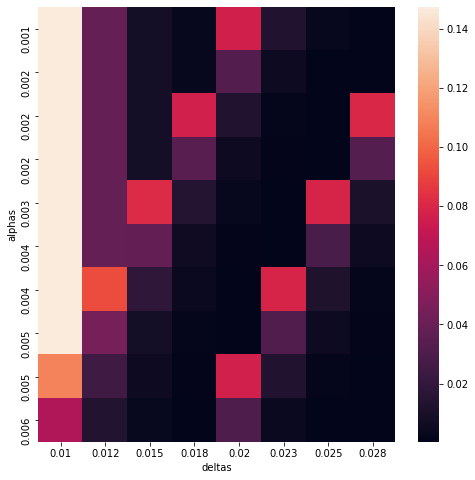

In [ ]:
import seaborn as sns

alphas = [round(i,3) for i in np.arange(0.001,0.006,0.0005)]
deltas = [round(i,3) for i in np.arange(0.01,0.03,0.0025)]

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(aft.T, yticklabels=alphas, xticklabels=deltas)
ax.set(xlabel='deltas', ylabel='alphas')


**Parameter selection**

By analysing this matrix, and since we prefer small deltas that do not disturb the image: We choose the values alpha = 0.006, delta = 0.03.

Intuitively, small alphas (step size) with longer iterations of the PGD algorithm can find precise maximas of the loss function yielding in the highest error (most vicious attack)

# Effect of iteration number on the power of the attack

In [8]:
batch_size = x_test.shape[0]

seed = 0 

alpha = 0.006
delta = 0.03

acc_advers_imgs = []

indices_chosen, _, _ = generate_adversarials_test_PGD(baseline,batch_size, delta, alpha, 1, seed)
v = baseline.evaluate(x=x_test[indices_chosen].reshape(-1,32,32,3), y=y_test[indices_chosen].reshape(-1,10), verbose=0)[1]
acc_advers_imgs.append(v)
print(f' Accuracy without attack, {round(acc_advers_imgs[-1]*100,4)} %')  #fix experiments randomness
for max_iter in range(1,11):
  _, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(baseline,batch_size, delta, alpha, max_iter, seed)
  acc_advers_imgs.append(baseline.evaluate(x=np.array(x_adversarial_train).reshape(-1,32,32,3), y=np.array(y_adversarial_train), verbose=0)[1])
  
  print(f' Accuracy for iter {max_iter}, delta = {delta}, alpha = {alpha}, {round(acc_advers_imgs[-1]*100,4)} %')

 Accuracy without attack, 83.58 %
 Accuracy for iter 1, delta = 0.03, alpha = 0.006, 49.71 %
 Accuracy for iter 2, delta = 0.03, alpha = 0.006, 15.68 %
 Accuracy for iter 3, delta = 0.03, alpha = 0.006, 3.27 %
 Accuracy for iter 4, delta = 0.03, alpha = 0.006, 0.52 %
 Accuracy for iter 5, delta = 0.03, alpha = 0.006, 0.12 %
 Accuracy for iter 6, delta = 0.03, alpha = 0.006, 0.05 %
 Accuracy for iter 7, delta = 0.03, alpha = 0.006, 0.04 %
 Accuracy for iter 8, delta = 0.03, alpha = 0.006, 0.02 %
 Accuracy for iter 9, delta = 0.03, alpha = 0.006, 0.02 %
 Accuracy for iter 10, delta = 0.03, alpha = 0.006, 0.02 %


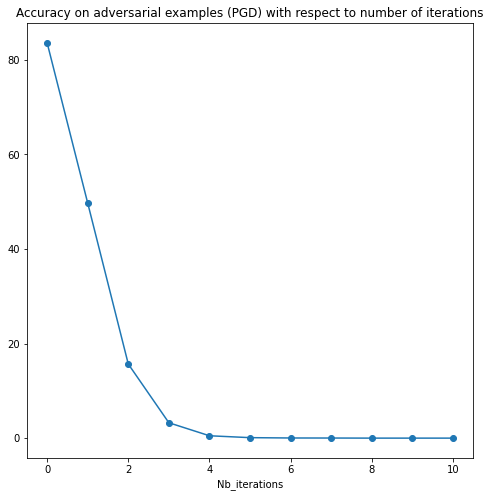

In [30]:
plt.figure(figsize=(8,8))
plt.plot(list(range(0,11)), 100*np.array(acc_advers_imgs), '-o')
plt.xlabel('Nb_iterations')
plt.title('Accuracy on adversarial examples (PGD) with respect to number of iterations')
plt.show()

* # The error decreases rapidly in the first iterations nb_iteration < 4, to reach values very close to 0.

# Run PGD on test set

In [ ]:
batch_size = 5000
alpha = 0.006
delta = 0.03
max_iter = 5

#fix experiments randomness
seed = 0 

indices_chosen, x_adversarial_test, y_adversarial_test = generate_adversarials_test_PGD(baseline, batch_size, delta, alpha, max_iter, seed)

In [ ]:
print(f'Accuracy on batch of test images =  {baseline.evaluate(x=x_test[indices_chosen].reshape(-1,32,32,3), y=y_test[indices_chosen].reshape(-1,10), verbose=0)[1]*100} %')
print(f'Accuracy on the same batch of test adversarial images for delta = {delta}, alpha = {alpha}, {baseline.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1]*100} %')

Accuracy on batch of test images =  84.11999940872192 %
Accuracy on the same batch of test adversarial images for delta = 0.03, alpha = 0.006, 0.019999999494757503 %


Before attack :
After attack :


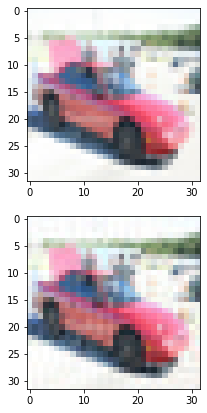

In [ ]:
ind = random.randint(0,batch_size-1)
plt.figure(figsize=(7,7))
print("Before attack :")
plt.subplot(2,1,1)
plt.imshow(x_test[indices_chosen[ind]].reshape(32,32,3))
print("After attack :")
plt.subplot(2,1,2)
plt.imshow(x_adversarial_test[ind].reshape(32,32,3))

# **PGD adversarial training :**

In the adversarial training, we use the following loss function as a minimizer of our network.

$$\tilde{J}(x,\theta,y) = a \cdot J(x, \theta, y) + (1-a) \cdot J(pgd(x), \theta, y)$$

The pgd attack will use the following parameters :
* alpha = 0.006
* delta = 0.03
* max_iter = 10
with a = 0.5


In [16]:
from keras.layers import Lambda
# hyperparameter
batch_size = 128
epoch = 51
a = 0.5
alpha = 0.006
delta = 0.03
max_iter = 10
seed = 0
nb_adv_examples = x_train.shape[0]//4

perf = {}
perf['loss'] = []
perf['val_loss'] = []

perf['original_output_accuracy'] = []
perf['adversarial_output_accuracy'] = []

perf['val_adversarial_output_accuracy'] = []
perf['val_original_output_accuracy'] = []


#model fitting
input_shape = x_train.shape[1:]

adv_model_pgd = build_model_base_CNN_no_c(input_shape)

branch1 = Input(input_shape)
branch2 = Input(input_shape)

normal_y = adv_model_pgd(branch1)
normal_y = Lambda(lambda x: x, name='original_output')(normal_y)
adv_y = adv_model_pgd(branch2)
adv_y = Lambda(lambda x: x, name='adversarial_output')(adv_y)

double_branch_net_pgd = Model([branch1,branch2],[normal_y,adv_y])

# compile model
double_branch_net_pgd.compile(optimizer=Adam(lr=0.01), loss={'original_output' : 'categorical_crossentropy', 'adversarial_output' : 'categorical_crossentropy'},
            loss_weights={'original_output' : a, 'adversarial_output' : 1.0-a},
            metrics={'original_output' : 'accuracy', 'adversarial_output' : 'accuracy'})



rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_adv_model_it5.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

for i in range(1,epoch+1):
  print("epoch = ",i)
  if i == 1 :
      ind, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(baseline, nb_adv_examples, delta, alpha, max_iter, seed)
      x_train_reg, y_train_reg = x_train[ind], y_train[ind]
      del ind

  history = double_branch_net_pgd.fit([x_train_reg,x_adversarial_train], [y_train_reg,y_adversarial_train], epochs=1, batch_size=batch_size,verbose=1,validation_split=0.1, callbacks = [rlrop, es, mc])
  
  _, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(adv_model_pgd, nb_adv_examples, delta, alpha, max_iter, seed)
  # x_train_reg, y_train_reg = x_train[ind], y_train[ind]
  # print(ind)
  for key in perf.keys():
    perf[key].append(history.history[key][0])


epoch =  1
88/88 [==============================] - ETA: 0s - loss: 2.5722 - original_output_loss: 2.5880 - adversarial_output_loss: 2.5564 - original_output_accuracy: 0.1706 - adversarial_output_accuracy: 0.1727
Epoch 00001: val_loss improved from inf to 2.03053, saving model to best_adv_model_it5.h5
88/88 [==============================] - 3s 36ms/step - loss: 2.5722 - original_output_loss: 2.5880 - adversarial_output_loss: 2.5564 - original_output_accuracy: 0.1706 - adversarial_output_accuracy: 0.1727 - val_loss: 2.0305 - val_original_output_loss: 2.0283 - val_adversarial_output_loss: 2.0328 - val_original_output_accuracy: 0.2400 - val_adversarial_output_accuracy: 0.2344
epoch =  2
86/88 [============================>.] - ETA: 0s - loss: 2.0075 - original_output_loss: 1.9549 - adversarial_output_loss: 2.0601 - original_output_accuracy: 0.2509 - adversarial_output_accuracy: 0.2236
Epoch 00001: val_loss improved from 2.03053 to 1.88748, saving model to best_adv_model_it5.h5
88/88 [===

Text(0.5, 0, 'Epoch')

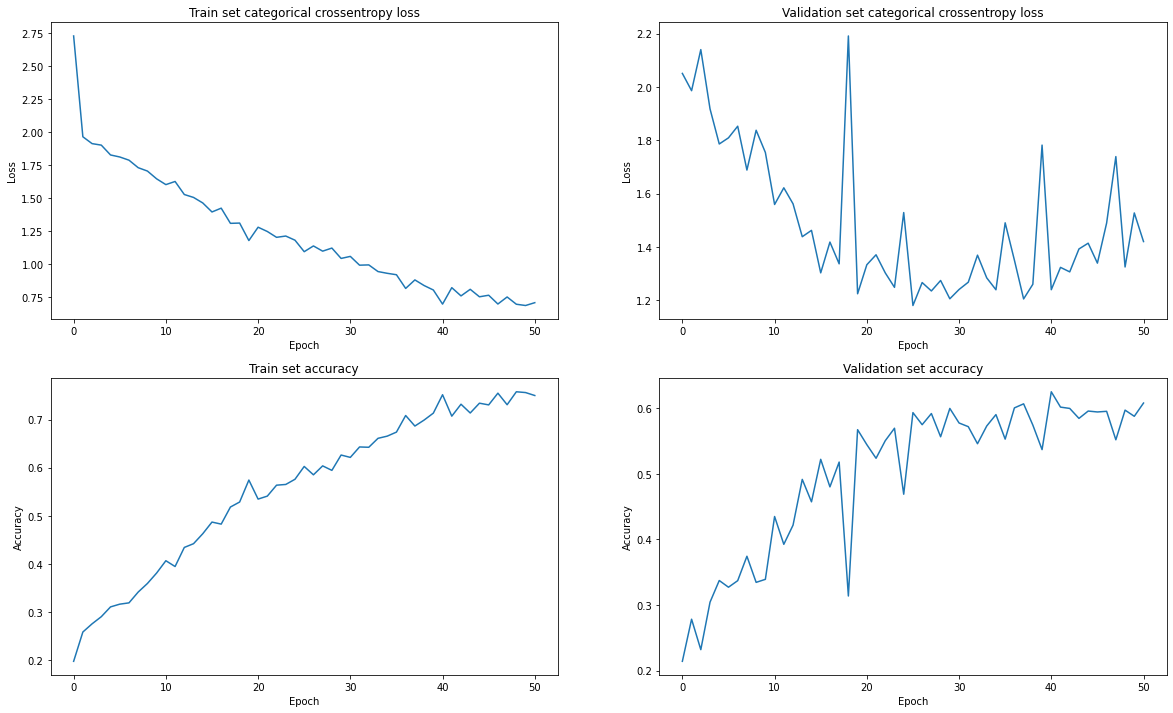

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(perf['loss'])
plt.title('Train set categorical crossentropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')


plt.subplot(222)
plt.plot(perf['val_loss'])
plt.title('Validation set categorical crossentropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(223)
plt.plot((np.array(perf['original_output_accuracy'])+np.array(perf['adversarial_output_accuracy']))/2)
plt.title('Train set accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(224)
plt.plot((np.array(perf['val_original_output_accuracy'])+np.array(perf['val_adversarial_output_accuracy']))/2)
plt.title('Validation set accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [18]:
## classification model for cifar10
def two_to_one_branch(input_shape,two_b_adv_model):
  i = Input(input_shape)  
  o = two_b_adv_model([i,i])[0]
  model = Model(i, o)
  return model

adv_model_pgd = load_model('best_adv_model_it5.h5')
model_adv = two_to_one_branch((32,32,3),adv_model_pgd)
model_adv.compile(loss = 'categorical_crossentropy', optimizer=Adam(0.001),metrics=['accuracy'])

In [19]:
alpha = 0.006
delta = 0.03
seed = 0
b_s = 5000

robust_accs_advs = []
ori_acc = model_adv.evaluate(x=x_test, y=y_test, verbose=0)[1]
print("Accuracy of robust model on regular images:", ori_acc)
robust_accs_advs.append(ori_acc)

for max_iter in range(1, 11):
    _, x_adversarial, y_adversarial = generate_adversarials_test_PGD(model_adv, b_s, delta, alpha, max_iter, seed)
    v = model_adv.evaluate(x=np.array(x_adversarial).reshape(-1,32,32,3), y=np.array(y_adversarial), verbose=0)[1]
    robust_accs_advs.append(v)
    print(f'Accuracy of robust model on adversarial images for max_iter {max_iter} : {v}')

Accuracy of robust model on regular images: 0.6215999722480774
Accuracy of robust model on adversarial images for max_iter 1 : 0.5098000168800354
Accuracy of robust model on adversarial images for max_iter 2 : 0.39500001072883606
Accuracy of robust model on adversarial images for max_iter 3 : 0.28540000319480896
Accuracy of robust model on adversarial images for max_iter 4 : 0.21060000360012054
Accuracy of robust model on adversarial images for max_iter 5 : 0.1518000066280365
Accuracy of robust model on adversarial images for max_iter 6 : 0.14020000398159027
Accuracy of robust model on adversarial images for max_iter 7 : 0.12780000269412994
Accuracy of robust model on adversarial images for max_iter 8 : 0.121799997985363
Accuracy of robust model on adversarial images for max_iter 9 : 0.11680000275373459
Accuracy of robust model on adversarial images for max_iter 10 : 0.11339999735355377


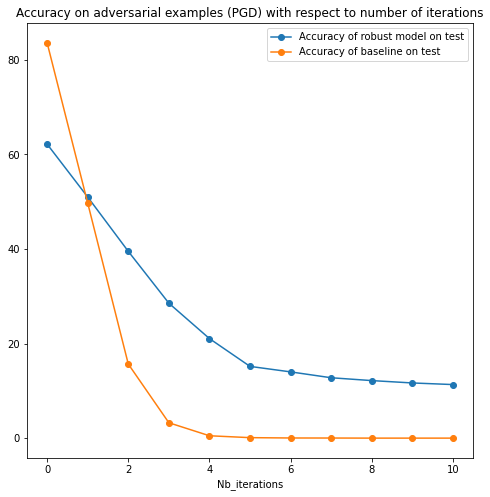

In [20]:
plt.figure(figsize=(8,8))
plt.plot(100*np.array(robust_accs_advs), '-o')
plt.plot(100*np.array(acc_advers_imgs), '-o')
plt.xlabel('Nb_iterations')
plt.title('Accuracy on adversarial examples (PGD) with respect to number of iterations')
plt.legend(['Accuracy of robust model on test','Accuracy of baseline on test '], loc='upper right')
plt.show()

**Results :**
* The accuracy on regular images drops from 80% to 60% which is normal in this case (We couldn't train the model for as long as the baseline model, so the difference might arise from that).
* The robust model performs better on attacked images than its regular counterpart stagnating at around 12% for iterations > 5, while the baseline model drops to 0% accuracy.
* The robust model is not that resilient to attacks because by nature, the PGD attacks are very powerful.

In [26]:
 _, x_adversarial, y_adversarial = generate_adversarials_test_PGD(model_adv, x_test.shape[0], 1, 0.02, 1, seed)
v = model_adv.evaluate(x=np.array(x_adversarial).reshape(-1,32,32,3), y=np.array(y_adversarial), verbose=0)[1]
print(f'Accuracy on adversarial example generated with PGD :{v}')

Accuracy on adversarial example generated with PGD :0.29589998722076416


* The defended model using PGD have a 30% accuracy on attacks done by FGSM.